In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


#### 1.2. Installing the Hugging Face Library

In [3]:
!pip install transformers

In [4]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

### 2. Loading Data

#### 2.1 TrainData

In [5]:
import pandas as pd

# Path to the input CSV file
local_csv_path = 'Rumour.csv'

# Load the dataset into a pandas dataframe
df = pd.read_csv(local_csv_path, encoding='latin-1')
df.head()

,text,is_rumor,user.handle,topic
0,Charlie Hebdo became well known for publishing...,0,BBCDanielS,charliehebdo
1,"Now 10 dead in a shooting there today RT ""@BBC...",0,robbylevy,charliehebdo
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0,ModerateInAll,charliehebdo
3,@BBCDanielS @BBCWorld why would you mention th...,0,GabTarquini,charliehebdo
4,@BBCDanielS @BBCWorld perps identified?,0,freethought41,charliehebdo


In [6]:
# Analysis of article length as a potential pattern
df['text_len'] = df['text'].apply(len)

Number of records: 62,445



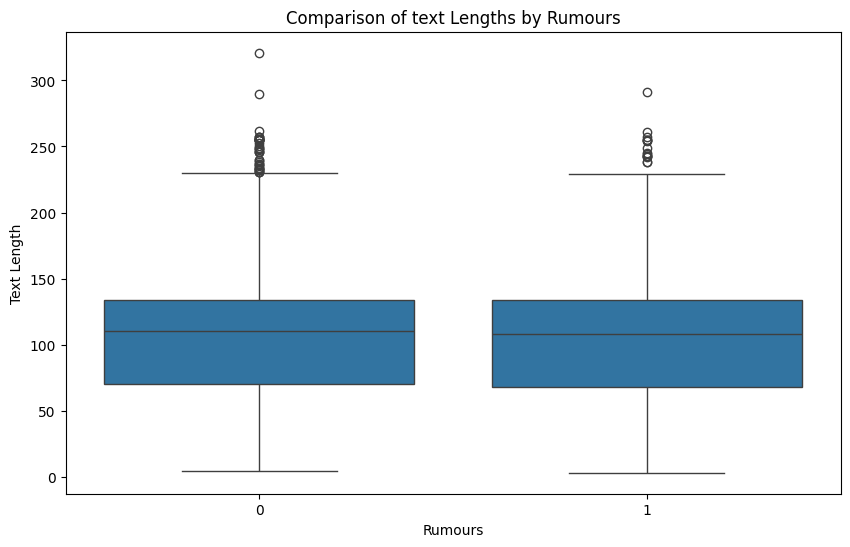

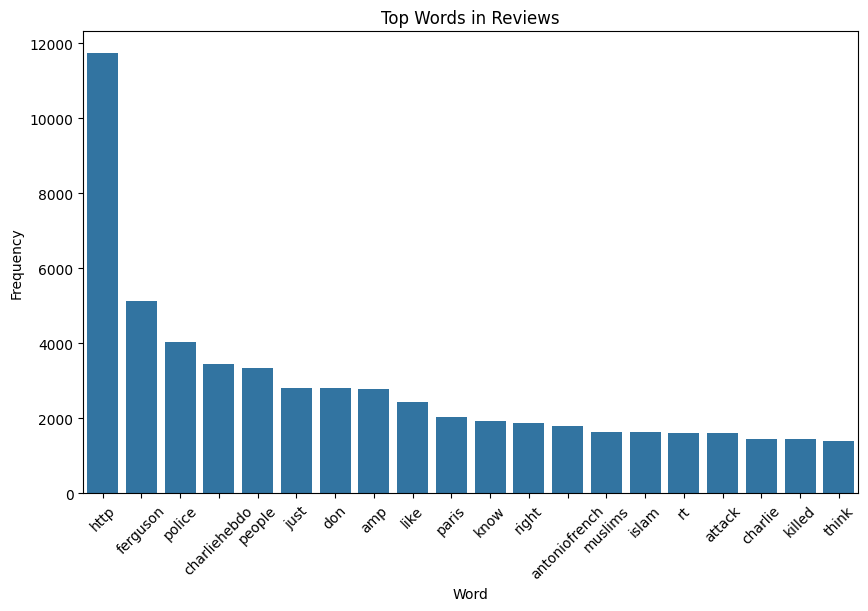

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


# Report the number of records
print('Number of records: {:,}\n'.format(df.shape[0]))

# Plot comparison of review lengths by sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_rumor', y='text_len', data=df)
plt.title('Comparison of text Lengths by Rumours')
plt.xlabel('Rumours')
plt.ylabel('Text Length')
plt.show()

# Word frequency analysis
def plot_top_n_words(text, n=20):
    vec = CountVectorizer(stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_words = words_freq[:n]
    top_df = pd.DataFrame(top_words, columns=["Word", "Freq"])

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x="Word", y="Freq", data=top_df)
    plt.xticks(rotation=45)
    plt.title('Top Words in Reviews')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.show()

# Plot top words in all reviews
plot_top_n_words(df['text'], n=20)


### 3. Pre-processing Text

In [8]:
# I have not written any code for text cleaning yet

In [9]:
# Creating a new DataFrame for training
train_df = df[['text', 'is_rumor']].rename(columns={'is_rumor': 'target'})

# Get the lists of sentences and labels
sentences = train_df['text'].values
labels = train_df['target'].values

# Display a specific sentence (e.g., the 10th row)
print(f"Sentence at index 10: {train_df['text'].iloc[10]}")

Sentence at index 10: @GabTarquini @BBCDanielS @BBCWorld Cossette, a broadcast journalist with Europe1 News. Hope that helps mate. From: http://t.co/dOP4uBRBSr


In [10]:
train_df

,text,target
0,Charlie Hebdo became well known for publishing...,0
1,"Now 10 dead in a shooting there today RT ""@BBC...",0
2,@BBCDanielS @BBCWorld I'm guessing this is bei...,0
3,@BBCDanielS @BBCWorld why would you mention th...,0
4,@BBCDanielS @BBCWorld perps identified?,0
...,...,...
62440,@AnonyOps @Xplant So that means its ok to torc...,1
62441,"@RianAlden not at all, but they need to change...",1
62442,@Xplant @AnonyOps Absoluteky. But it pains me...,1
62443,@Xplant @AnonyOps I'm curious how many of thes...,1


### 4. Initializing the pre-trained models

Let's initialize the models with pre-trained weights. The list of pre-trained weights is available in [the official documentation](https://huggingface.co/transformers/pretrained_models.html). Downloading the weights may take a bit of time, but it only needs to be done once!

In [11]:
# loading pre-trained models
from transformers import AdamW

c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
# BERT
from transformers import BertForSequenceClassification, BertTokenizer

bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Comment out or remove this line if CUDA is not available
# bert_model.cuda()

print('Base models loaded')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Base models loaded


### 5. Tokenization

BERT and RoBERTa are both Transformer models that have the same architecture. As such, they accept only a certain kind of inputs: vectors of integers, each value representing a token. Each string of text must first be converted to a list of indices to be fed to the model. The tokenizer takes care of that for us.

BERT and RoBERTa may have the same architecture, but they differ in tokenization. BERT uses a sub-word tokenization, whereas RoBERTa uses the same tokenization than GPT-2: byte-level byte-pair-encoding. Let's see what this means:

Let's apply the tokenizer to one sentence just to see the output.

In [13]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the tweet split into tokens.
print('Tokenized BERT: ', bert_tokenizer.tokenize(sentences[0]))

# Print the tweet mapped to token ids.
print('Token IDs BERT: ', bert_tokenizer.convert_tokens_to_ids(bert_tokenizer.tokenize(sentences[0])))


 Original:  Charlie Hebdo became well known for publishing the Muhammed cartoons two years ago
Tokenized BERT:  ['charlie', 'he', '##b', '##do', 'became', 'well', 'known', 'for', 'publishing', 'the', 'mu', '##ham', '##med', 'cartoons', 'two', 'years', 'ago']
Token IDs BERT:  [4918, 2002, 2497, 3527, 2150, 2092, 2124, 2005, 4640, 1996, 14163, 3511, 7583, 13941, 2048, 2086, 3283]


We see a stark difference between how BERT and RoBERTa tokenize sentences

In [14]:
sequence = """@GabTarquini @BBCDanielS @BBCWorld Scared of the truth MOSLEM?  Your peaceful islam has their bloody hands in yet another murderous rampage"""

bert_tokenized_sequence = bert_tokenizer.tokenize(sequence)

print("""@GabTarquini @BBCDanielS @BBCWorld Scared of the truth MOSLEM?  Your peaceful islam has their bloody hands in yet another murderous rampage""")
print("BERT:", bert_tokenized_sequence)

@GabTarquini @BBCDanielS @BBCWorld Scared of the truth MOSLEM?  Your peaceful islam has their bloody hands in yet another murderous rampage
BERT: ['@', 'ga', '##bt', '##ar', '##quin', '##i', '@', 'bbc', '##dan', '##iel', '##s', '@', 'bbc', '##world', 'scared', 'of', 'the', 'truth', 'mo', '##sle', '##m', '?', 'your', 'peaceful', 'islam', 'has', 'their', 'bloody', 'hands', 'in', 'yet', 'another', 'murderous', 'rampage']


**BERT Tokenizer**

Here, the BERT tokenizer splits the string into multiple substrings. If the substrings are in its vocabulary, they will stay as is: this is the case for `Cities`, `Taking` and `List`. However, if a resulting string is not in its vocabulary, it will be split again until every string is represented by its vocabulary. For example, `Transplanted` is split multiple times until every token is represented in the BERT vocabulary: it is split into three tokens.
The BERT tokenizer is lacking when it comes to complex characters spread over multiple bytes, as can be seen with emojis. In the sequence used, an emoji of a Cityscape was added. As the BERT tokenizer cannot interpret this emoji on a byte-level, it replaces it by the unknown token [UNK].

**RoBERTa Tokenizer**

On the other hand, the RoBERTa tokenizer has a slightly different approach. Here too, the string is split into multiple substrings, which are themselves split into multiple substrings until every substring can be represented by the vocabulary. However, the RoBERTa tokenizer has a **byte-level approach**. This tokenizer can represent every sequence as a combination of bytes, which makes it shine in the case of complex characters spread over multiple bytes, as with the Cityscape emoji. Instead of using the unknown token, this tokenizer can correctly encode the Cityscape emoji as the combination of multiple bytes. This tokenizer therefore does not require an unknown token, as it can handle every byte separately.

The transformers library provides a helpful encode function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a maximum sentence length for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [15]:
max_len_bert = 0
# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_bert = bert_tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_bert = max(max_len_bert, len(input_ids_bert))
    
print('Max sentence length BERT: ', max_len_bert)


Max sentence length BERT:  186


Just in case there are some longer test sentences, I'll set the maximum length to 120.

Now we're ready to perform the real tokenization.

The tokenizer.encode_plus function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special [CLS] and [SEP] tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
6. The first four features are in tokenizer.encode, but I'm using tokenizer.encode_plus to get the fifth item (attention masks)

In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
bert_input_ids = []
bert_attention_masks = []
sentence_ids = []
counter = 0

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    bert_encoded_dict = bert_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    
    # Add the encoded sentence to the list.    
    bert_input_ids.append(bert_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    bert_attention_masks.append(bert_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
    
    
# Convert the lists into tensors.
bert_input_ids = torch.cat(bert_input_ids, dim=0)
bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs BERT:', bert_input_ids[1])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Now 10 dead in a shooting there today RT "@BBCDanielS: Charlie Hebdo became well known for publishing the Muhammed cartoons two years agoâ
Token IDs BERT: tensor([  101,  2085,  2184,  2757,  1999,  1037,  5008,  2045,  2651, 19387,
         1000,  1030,  4035,  7847,  9257,  2015,  1024,  4918,  2002,  2497,
         3527,  2150,  2092,  2124,  2005,  4640,  1996, 14163,  3511,  7583,
        13941,  2048,  2086,  3283,  2050,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   

In [17]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
bert_dataset = TensorDataset(sentence_ids, bert_input_ids, bert_attention_masks, labels)

In [18]:
# function to remove sentice ids from the tensor dataset post train test split
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset
        
# check
trial_dataset =  index_remover(bert_dataset)
trial_dataset[0]
# yes we were able to remove the sentence id from the data without disturbing the data format

(tensor([  101,  4918,  2002,  2497,  3527,  2150,  2092,  2124,  2005,  4640,
          1996, 14163,  3511,  7583, 13941,  2048,  2086,  3283,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [19]:
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(bert_dataset))
val_size = len(bert_dataset) - train_size

# Divide the dataset by randomly selecting samples.
bert_train_dataset, bert_val_dataset = random_split(bert_dataset, [train_size, val_size])

# Checking whether the distribution of target is consitent across both the sets
sentence_ids_list_valid = []
for a,b,c,d in bert_val_dataset:
  sentence_ids_list_valid.append(a.tolist())

# removing sentence ids from tensor dataset so that it can be used for training 
bert_train_dataset = index_remover(bert_train_dataset)
bert_val_dataset = index_remover(bert_val_dataset)

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in bert_train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real disater tweets'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in bert_val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real disater tweets'.format(sum(label_temp_list)))

56,200 training samples
12,411 training samples with real disater tweets
6,245 validation samples
1,415 validation samples with real disater tweets


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )


# For validation the order doesn't matter, so we'll just read them sequentially.
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )



Browsing all of the model's parameters by name here.

In the below cell, we have names and dimensions of the weights for:

The embedding layer.
The first of the twelve transformers.
The output layer

### 7. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values :

Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
We chose:

Batch size: 32 (set when creating our DataLoaders)
Learning rate: 2e-5
Epochs: 4 (we'll see that this is probably too many...)
The epsilon parameter eps = 1e-8 is "a very small number to prevent any division by zero in the implementation"

In [21]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )



c:\Python311\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2,I have already seen that the model starts overfitting beyound 2 epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


### 8. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase.

**Training:**

1. Unpack our data inputs and labels
2. Load data onto the GPU for acceleration
3. Clear out the gradients calculated in the previous pass.
4. In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
5. Forward pass (feed input data through the network)
6. Backward pass (backpropagation)
7. Tell the network to update parameters with optimizer.step()
8. Track variables for monitoring progress

**Evaluation:**

1. Unpack our data inputs and labels
2. Load data onto the GPU for acceleration
3. Forward pass (feed input data through the network)
4. Compute loss on our validation data and track variables for monitoring progress
5. Define a helper function for calculating accuracy.

In [23]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as hh:mm:ss

In [24]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready to kick off the training!

#### 8.1 BERT

In [25]:
import numpy as np
import random
import time
import torch
from transformers import AdamW, get_linear_schedule_with_warmup

# Assuming the definition of `bert_model`, `bert_optimizer`, and `bert_scheduler` are done elsewhere
# Make sure to import necessary libraries and define or import your model, optimizer, scheduler, and dataloaders before this script

# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Assuming `device` is defined (e.g., 'cuda' or 'cpu')
bert_model.to(device)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
bert_training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

epochs = 4  # Assuming `epochs` is defined

# Function to format time elapsed into hh:mm:ss
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    bert_model.train()

    for step, batch in enumerate(bert_train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        bert_model.zero_grad()        

        outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

        loss = outputs.loss
        logits = outputs.logits

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        bert_optimizer.step()
        bert_scheduler.step()

    avg_train_loss = total_train_loss / len(bert_train_dataloader)
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    
    print("")
    print("Running Validation...")

    t0 = time.time()

    bert_model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in bert_validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            outputs = bert_model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        
        loss = outputs.loss
        logits = outputs.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(bert_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(bert_validation_dataloader)
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    bert_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))



======== Epoch 1 / 4 ========
Training...
  Batch    40  of  1,757.    Elapsed: 0:10:33.
  Batch    80  of  1,757.    Elapsed: 0:21:19.
  Batch   120  of  1,757.    Elapsed: 0:31:44.
  Batch   160  of  1,757.    Elapsed: 0:42:30.
  Batch   200  of  1,757.    Elapsed: 0:52:16.
  Batch   240  of  1,757.    Elapsed: 1:00:40.
  Batch   280  of  1,757.    Elapsed: 1:09:47.
  Batch   320  of  1,757.    Elapsed: 1:19:05.
  Batch   360  of  1,757.    Elapsed: 1:27:59.
  Batch   400  of  1,757.    Elapsed: 1:36:42.
  Batch   440  of  1,757.    Elapsed: 1:45:49.
  Batch   480  of  1,757.    Elapsed: 1:53:42.
  Batch   520  of  1,757.    Elapsed: 2:01:32.
  Batch   560  of  1,757.    Elapsed: 2:09:34.
  Batch   600  of  1,757.    Elapsed: 2:17:25.
  Batch   640  of  1,757.    Elapsed: 2:25:17.
  Batch   680  of  1,757.    Elapsed: 2:33:12.
  Batch   720  of  1,757.    Elapsed: 2:41:29.
  Batch   760  of  1,757.    Elapsed: 2:49:32.
  Batch   800  of  1,757.    Elapsed: 2:57:34.
  Batch   840  of

In [32]:
# Save the trained model, the optimizer, and the scheduler. You can also include the epoch number if you want.
model_save_path = "bert.bin"

torch.save({
    'model_state_dict': bert_model.state_dict(),
    'optimizer_state_dict': bert_optimizer.state_dict(),
    'scheduler_state_dict': bert_scheduler.state_dict(),
    'training_stats': bert_training_stats,
    # Add any other things you need
}, model_save_path)


In [33]:
# Load the model and optimizer state dict
checkpoint = torch.load(model_save_path)

# Load model state
bert_model.load_state_dict(checkpoint['model_state_dict'])

# If you're continuing training, you'll also want to load the optimizer and scheduler states
bert_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
bert_scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Don't forget to move the model to the right device after loading
bert_model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [34]:
print(device)

cpu


# Prediction

In [35]:
import torch
from transformers import BertTokenizer,  BertForSequenceClassification

import torch
from transformers import BertTokenizer,  BertForSequenceClassification

def load_model(model_path, model_class, tokenizer_class):
    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    
    # Initialize the model and tokenizer
    model = model_class.from_pretrained("bert-base-uncased" if "bert" in model_path else "roberta-base", 
                                        num_labels=2, 
                                        output_attentions=False,
                                        output_hidden_states=False,
                                        ignore_mismatched_sizes=True)  # Add this to ignore size mismatches

    tokenizer = tokenizer_class.from_pretrained("bert-base-uncased" if "bert" in model_path else "roberta-base")
    
    # Load the trained model parameters, ignoring missing keys
    missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    print("Missing keys:", missing_keys)
    print("Unexpected keys:", unexpected_keys)
    model.eval()  # Set the model to evaluation mode
    
    return model, tokenizer


def predict(input_text, model, tokenizer):
    # Encode the input text
    encoded_dict = tokenizer.encode_plus(
                        text=input_text,
                        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                        max_length=64,  # Pad & truncate all sentences.
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',  # Return PyTorch tensors
                   )
    
    # Extract inputs from the encoded dictionary
    input_ids = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    
    # Model prediction
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
    
    logits = outputs[0]
    predicted_prob = torch.softmax(logits, dim=1).numpy().flatten()  # Convert logits to probabilities
    prediction = torch.argmax(logits, dim=1).numpy().flatten()[0]  # Get the predicted class index
    
    return prediction, predicted_prob

# Load the model and tokenizer
model_path = 'bert.bin'  # or 'roberta_model.bin'
model_class = BertForSequenceClassification  # or RobertaForSequenceClassification for RoBERTa
tokenizer_class = BertTokenizer  # or RobertaTokenizer for RoBERTa

model, tokenizer = load_model(model_path, model_class, tokenizer_class)

# Predict user input

user_input = "!!!Kaç Recep[@rt_erDOGan] kaç geliyorlar! @RT_com"


prediction, probabilities = predict(user_input, model, tokenizer)

print("Prediction:", " NOT RUMOUR" if prediction == 1 else "RUMOR")
print("Probabilities:", probabilities)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Missing keys: []
Unexpected keys: []
Prediction:  NOT RUMOUR
Probabilities: [0.08015186 0.9198482 ]


In [36]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

def load_model(model_path, model_class, tokenizer_class):
    # Load the checkpoint
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    
    # Initialize the model and tokenizer
    model = model_class.from_pretrained("bert-base-uncased" if "bert" in model_path else "roberta-base", 
                                        num_labels=2, 
                                        output_attentions=False,
                                        output_hidden_states=False,
                                        ignore_mismatched_sizes=True)  # Add this to ignore size mismatches

    tokenizer = tokenizer_class.from_pretrained("bert-base-uncased" if "bert" in model_path else "roberta-base")
    
    # Load the trained model parameters, ignoring missing keys
    missing_keys, unexpected_keys = model.load_state_dict(checkpoint['model_state_dict'], strict=False)
    print("Missing keys:", missing_keys)
    print("Unexpected keys:", unexpected_keys)
    model.eval()  # Set the model to evaluation mode
    
    return model, tokenizer

def predict(input_text, model, tokenizer):
    # Encode the input text
    encoded_dict = tokenizer.encode_plus(
                        text=input_text,
                        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                        max_length=64,  # Pad & truncate all sentences.
                        pad_to_max_length=True,
                        return_attention_mask=True,
                        return_tensors='pt',  # Return PyTorch tensors
                   )
    
    # Extract inputs from the encoded dictionary
    input_ids = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    
    # Model prediction
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
    
    logits = outputs[0]
    predicted_prob = torch.softmax(logits, dim=1).numpy().flatten()  # Convert logits to probabilities
    prediction = torch.argmax(logits, dim=1).numpy().flatten()[0]  # Get the predicted class index
    
    return prediction, predicted_prob

def get_score(probabilities):
    positive_prob = probabilities[1]  # Probability of the positive class
    score = int(round(positive_prob * 5))  # Scale to a range between 1 and 5
    score = max(1, min(score, 5))  # Ensure the score is within the range [1, 5]
    return score

# Load the model and tokenizer
model_path = 'bert.bin'  # or 'roberta_model.bin'
model_class = BertForSequenceClassification  # or RobertaForSequenceClassification for RoBERTa
tokenizer_class = BertTokenizer  # or RobertaTokenizer for RoBERTa

model, tokenizer = load_model(model_path, model_class, tokenizer_class)

# Predict user input
user_input = "Tam manasıyla pisliksin @EmreUslu  "

prediction, probabilities = predict(user_input, model, tokenizer)
score = get_score(probabilities)

print("Prediction:", "NOT RUMOR" if prediction == 1 else "RUMOR")
print("Probabilities:", probabilities)
print("Score out of 5:", score)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Missing keys: []
Unexpected keys: []
Prediction: RUMOR
Probabilities: [0.9925156  0.00748442]
Score out of 5: 1
